In [1]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import typing as t

from matplotlib import pyplot
import matplotlib.patches as patches

import numpy
from numpy.typing import NDArray, ArrayLike

from phaser.utils.num import to_numpy, abs2, fft2, ifft2

import cupy

In [ ]:
from pathlib import Path

from phaser.plan import ReconsPlan

plan = ReconsPlan.from_data({
    'backend': 'cupy',

    'raw_data': {
        'type': 'empad',
        'path': "~/Downloads/mos2/1/mos2/mos2_0.00_dstep1.0_x64_y64_4DSTEM.raw",
        'diff_step': 1.0,
        'kv': 120.,
    },

    'init_probe': {
        'type': 'focused',
        'conv_angle': 25.0,
        'defocus': 300.0,
    },

    'init_object': 'random',

    'init_scan': {
        'type': 'raster',
        'shape': [64, 64],
        'step_size': 0.6
    },

    'preprocessing': [{
        'type': 'scale',
        'scale': 1.0e+6,
    }],

    'engines': [
        {
            'type': 'conventional',
            'probe_modes': 4,
            'niter': 50,
            'grouping': 64,
            'noise_model': {
                'type': 'amplitude',
                'eps': 0.1,
            },
            'solver': {
                'type': 'lsqml',
                'beta_probe': 1.0,
                'beta_object': 1.0,
                'gamma': 1.0e-4,
                'illum_reg_object': 1.0e-2,
                'illum_reg_probe': 1.0e-2,
            },
            'regularizers': [],
            'update_probe': {'after': 1},
            'update_positions': False
        },
        {
            'type': 'conventional',
            'probe_modes': 4,
            'niter': 50,
            'grouping': 64,
            'noise_model': {
                'type': 'amplitude',
                'eps': 0.1,
            },
            'solver': {
                'type': 'lsqml',
                'beta_probe': 1.0,
                'beta_object': 1.0,
                'gamma': 1.0e-4,
                'illum_reg_object': 1.0e-2,
                'illum_reg_probe': 1.0e-2,
            },
            'regularizers': [],
            'update_probe': True,
            'update_positions': True,
        },
    ]
})

In [3]:
from phaser.execute import initialize_reconstruction, prepare_for_engine, Observer

class MyObserver(Observer):
    def update_group(self, state, force: bool = False):
        super().update_group(state)

    def update_iteration(self, state, i: int, n: int, error: t.Optional[float] = None):
        super().update_iteration(state, i, n, error=error)

xp = cupy
dtype = numpy.float32
observer = MyObserver()
(patterns, state) = initialize_reconstruction(plan, xp, observer)

INFO:root:Executing plan...
INFO:root:dtype: <class 'numpy.float32'> array backend: cupy
INFO:root:dtype: <class 'numpy.float32'> array backend: cupy
INFO:root:Initializing probe...
INFO:phaser.hooks.probe:Making probe, conv_angle 25.0 mrad, defocus 300.0 A
INFO:root:Initializing scan...
INFO:root:Initializing object...
INFO:phaser.hooks.preprocessing:Adding poisson noise to raw patterns, after scaling by 1.00e+06


In [4]:
from phaser.plan import ConventionalEnginePlan

engine = plan.engines[0]
engine_plan = t.cast(ConventionalEnginePlan, engine.props)
patterns, state = prepare_for_engine(patterns, state, xp, engine_plan)
state = engine({
    'data': patterns,
    'state': state,
    'dtype': dtype,
    'xp': xp,
    'engine_i': 0,
    'observer': observer,
})

INFO:phaser.engines.conventional.run:Starting engine #1...
INFO:phaser.engines.conventional.solvers:Pre-calculated intensities
INFO:phaser.engines.conventional.solvers:Rescaling initial probe intensity by 1.00e+06
INFO:root:Engine initialized
INFO:root:Finished iter  1/50 [00:00.715] Error: 6.703e+03
INFO:root:Finished iter  2/50 [00:00.750] Error: 2.393e+03
INFO:root:Finished iter  3/50 [00:00.750] Error: 1.744e+03
INFO:root:Finished iter  4/50 [00:00.747] Error: 1.697e+03
INFO:root:Finished iter  5/50 [00:00.748] Error: 1.656e+03
INFO:root:Finished iter  6/50 [00:00.749] Error: 1.621e+03
INFO:root:Finished iter  7/50 [00:00.752] Error: 1.590e+03
INFO:root:Finished iter  8/50 [00:00.749] Error: 1.563e+03
INFO:root:Finished iter  9/50 [00:00.747] Error: 1.540e+03
INFO:root:Finished iter 10/50 [00:00.750] Error: 1.520e+03
INFO:root:Finished iter 11/50 [00:00.751] Error: 1.502e+03
INFO:root:Finished iter 12/50 [00:00.752] Error: 1.487e+03
INFO:root:Finished iter 13/50 [00:00.752] Error: 

Total time: 00:00:42.198


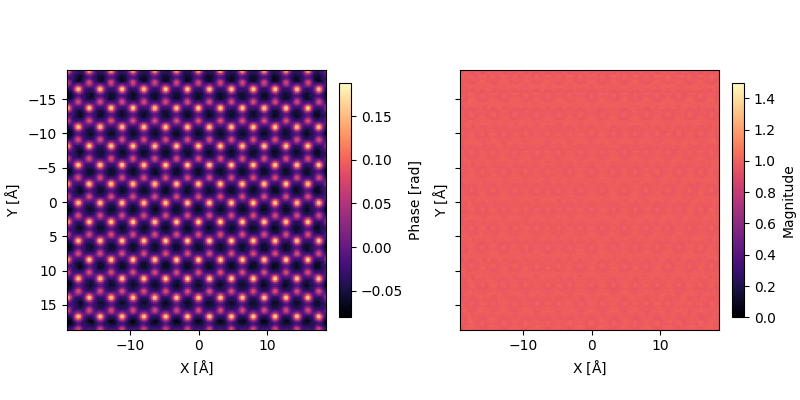

In [5]:
from phaser.utils.plotting import plot_object_phase, plot_object_mag

fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(8., 4.)

fig.colorbar(plot_object_phase(state.object, ax=axs[0], cmap='magma'), label="Phase [rad]", shrink=0.6)
fig.colorbar(plot_object_mag(state.object, ax=axs[1], cmap='magma', vmin=0., vmax=1.5), label="Magnitude", shrink=0.6)

pyplot.show()

In [6]:
state.probe.sampling.sampling  # A/px

array([0.26165751, 0.26165751])

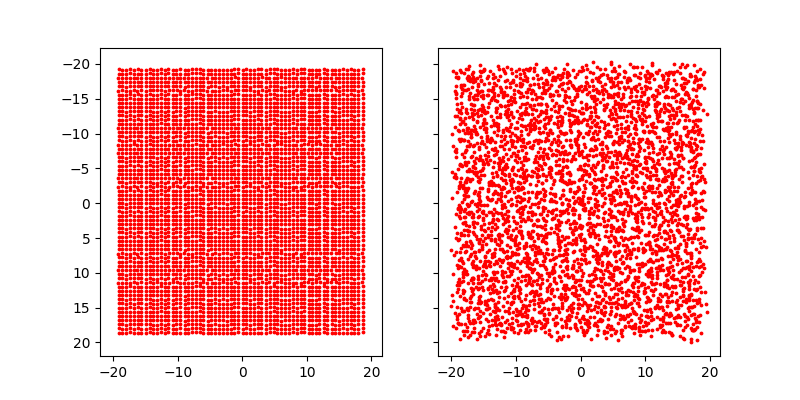

In [16]:
# perturb state with scan noise

mod_state = state.copy()

rng = numpy.random.default_rng(25534)
mod_state.scan += xp.array(rng.normal(scale=0.5, size=mod_state.scan.shape))

fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8., 4.)

axs[0].scatter(to_numpy(state.scan[..., 1]), to_numpy(state.scan[..., 0]), s=3, c='red')
axs[1].scatter(to_numpy(mod_state.scan[..., 1]), to_numpy(mod_state.scan[..., 0]), s=3, c='red')

axs[0].invert_yaxis()

pyplot.show()

In [17]:
from phaser.engines.conventional.solvers import *
from phaser.engines.common.noise_models import AmplitudeNoiseModel

@partial(
    jit,
    donate_argnames=('sim', 'obj_mag', 'probe_mag', 'new_obj_mag', 'new_probe_mag'),
    static_argnames=('update_object', 'update_probe', 'calc_error'),
)
def lsqml_run(
    sim: SimulationState,
    group: NDArray[numpy.integer], *,
    props: t.Optional[NDArray[numpy.complexfloating]],
    obj_mag: NDArray[numpy.floating],
    probe_mag: NDArray[numpy.floating],
    new_obj_mag: NDArray[numpy.floating],
    new_probe_mag: NDArray[numpy.floating],
    beta_object: float = 0.9,
    beta_probe: float = 0.9,
    update_object: bool = True,
    update_probe: bool = True,
    calc_error: bool = True,
    illum_reg_object: float,
    illum_reg_probe: float,
    gamma: float,
):
    xp = cast_array_module(sim.xp)
    obj_grid = sim.state.object.sampling
    n_slices = sim.state.object.data.shape[0]

    eps = 1e-16

    (probes, group_obj, group_scan, subpx_filters) = cutout_group(sim, group, return_filters=True)
    psi = xp.zeros((n_slices, *probes.shape), dtype=probes.dtype)
    psi = at(psi, 0).set(probes)

    group_probe_mag = xp.zeros_like(probe_mag)
    #group_obj_mag = xp.sum(abs2(group_obj[:, 0]), axis=0)
    group_obj_mag = xp.sum(abs2(xp.prod(group_obj, axis=1)), axis=0)

    def sim_slice(slice_i: int, prop: t.Optional[NDArray[numpy.complexfloating]], state):
        (group_probe_mag, psi) = state

        group_probe_mag = at(group_probe_mag, slice_i).set(
            obj_grid.add_view_at_pos(group_probe_mag[slice_i], group_scan, xp.sum(abs2(psi[slice_i]), axis=1))
        )

        if prop is not None:
            psi = at(psi, slice_i + 1).set(
                ifft2(fft2(psi[slice_i] * group_obj[:, slice_i, None]) * prop)
            )

        return (group_probe_mag, psi)

    (group_probe_mag, psi) = slice_forwards(props, (group_probe_mag, psi), sim_slice)

    new_obj_mag += group_obj_mag
    new_probe_mag += group_probe_mag

    model_wave = fft2(psi[-1] * group_obj[:, -1, None])
    # sum over incoherent modes
    model_intensity = xp.sum(abs2(model_wave), axis=1, keepdims=True)
    # experimental data
    group_patterns = xp.array(sim.patterns[*group])[:, None]

    errors = xp.sqrt(xp.nansum((model_intensity - group_patterns)**2, axis=(1, -1, -2))) if calc_error else None

    (chi, sim.noise_model_state) = sim.noise_model.calc_wave_update(model_wave, model_intensity, group_patterns, sim.pattern_mask, sim.noise_model_state)
    chi = ifft2(chi)

    def update_slice(slice_i: int, prop: t.Optional[NDArray[numpy.complexfloating]], state):
        (sim, chi) = state

        delta_P = chi * xp.conj(group_obj[:, slice_i, None])

        if update_object:
            delta_O = chi * xp.conj(psi[slice_i])
            alpha_O = xp.sum(xp.sum(xp.real(chi * xp.conj(delta_O * psi[slice_i])), axis=(-1, -2), keepdims=True), axis=1) / (xp.sum(abs2(delta_O * psi[slice_i])) + gamma)

            # average object update
            delta_O_avg = xp.zeros_like(sim.state.object.data[0])
            delta_O_avg = obj_grid.add_view_at_pos(delta_O_avg, group_scan, xp.sum(delta_O, axis=1))
            delta_O_avg /= (group_probe_mag[slice_i] + illum_reg_object)

            obj_update = beta_object * xp.sum(alpha_O * delta_O_avg * group_probe_mag[slice_i], axis=0) / (group_probe_mag[slice_i] + eps)
            sim.state.object.data = at(sim.state.object.data, slice_i).add(obj_update)

        if prop is not None:
            chi = ifft2(fft2(delta_P) * prop.conj())
        elif update_probe:
            delta_P_avg = ifft2(xp.sum(fft2(delta_P) * subpx_filters.conj(), axis=0))
            delta_P_avg /= (group_obj_mag + illum_reg_probe)

            # update step per probe mode
            alpha_P = xp.sum(xp.real(chi * xp.conj(delta_P * group_obj[:, slice_i, None])), axis=(-1, -2), keepdims=True) / (xp.sum(abs2(delta_P * group_obj[:, slice_i, None])) + gamma)

            probe_update = beta_probe * xp.sum(alpha_P * delta_P_avg * group_obj_mag, axis=0) / (group_obj_mag + eps)
            sim.state.probe.data += probe_update

        return (sim, chi)

    (sim, chi) = slice_backwards(props, (sim, chi), update_slice)

    return (sim, chi, obj_mag, probe_mag, new_obj_mag, new_probe_mag, errors)


engine_plan = t.cast(ConventionalEnginePlan, plan.engines[0].props)
solver_plan = t.cast(LSQMLSolverPlan, engine_plan.solver.props)

noise_model = engine_plan.noise_model(None)
regularizers = tuple(reg(None) for reg in engine_plan.regularizers)

sim = SimulationState(
    state=mod_state, noise_model=noise_model, regularizers=regularizers,
    patterns=patterns.patterns, pattern_mask=patterns.pattern_mask,
    xp=xp, dtype=dtype
)

groups = create_sparse_groupings(sim.state.scan, 128)
props = make_propagators(sim)

# pre calc mags
obj_mag = xp.zeros(sim.state.probe.data.shape[-2:], dtype=dtype)
probe_mag = xp.zeros_like(sim.state.object.data, dtype=dtype)

# dry run to pre-compute obj_mag and probe_mag
for (group_i, group) in enumerate(groups):
    (obj_mag, probe_mag, group_rescale_factors) = lsqml_dry_run(sim, props, group, obj_mag, probe_mag)

new_obj_mag = xp.zeros_like(obj_mag)
new_probe_mag = xp.zeros_like(probe_mag)

# now run one group

group = groups[0]
(sim, chi, obj_mag, probe_mag, new_obj_mag, new_probe_mag, errors) = lsqml_run(
    sim, group, props=props,
    obj_mag=obj_mag, probe_mag=probe_mag,
    new_obj_mag=new_obj_mag, new_probe_mag=new_probe_mag,
    beta_object=solver_plan.beta_object,
    beta_probe=solver_plan.beta_probe,
    update_object=False,
    update_probe=False,
    calc_error=True,
    illum_reg_object=solver_plan.illum_reg_object,
    illum_reg_probe=solver_plan.illum_reg_probe,
    gamma=solver_plan.gamma,
)

In [21]:
delta_P_x.shape

(128, 4, 128, 128)

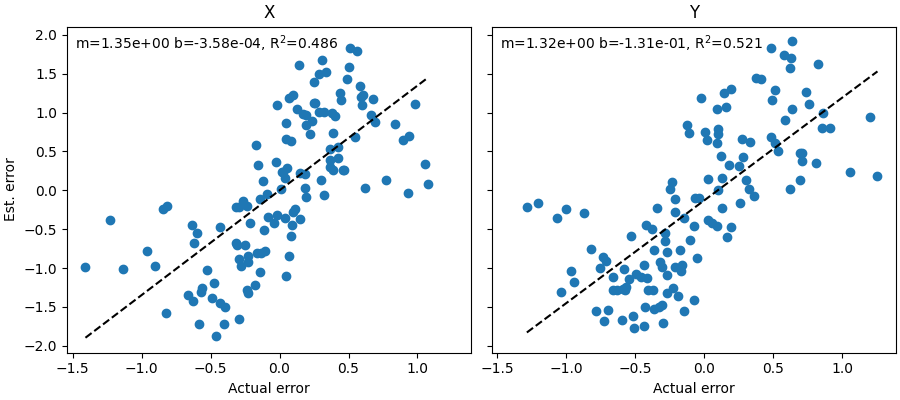

In [20]:
import scipy.stats

def plot_scatter(ax, xs, ys):
    ax.scatter(xs, ys)

    result = scipy.stats.linregress(xs, ys)

    xx = numpy.linspace(numpy.nanmin(xs), numpy.nanmax(xs), 100)

    ax.annotate(f"m={result.slope:.2e} b={result.intercept:.2e}, $\\mathrm{{R}}^2$={result.rvalue**2:.3f}", (0.02, 0.98), xycoords='axes fraction', va='top', ha='left')  # type: ignore

    ax.plot(xx, xx * result.slope + result.intercept, '--', color='black')  # type: ignore


(probes, group_obj, group_scan, subpx_filters) = cutout_group(sim, group, return_filters=True)
scan_error = mod_state.scan[*group] - state.scan[*group]

yy, xx = map(xp.array, sim.state.probe.sampling.real_grid())

shift_mag = 1e0
delta_P_x = ifft2(fft2(probes) * 2.j*numpy.pi * sim.kx * shift_mag)
delta_P_x /= xp.sum(abs2(probes), axis=(1, -1, -2), keepdims=True)
delta_P_y = ifft2(fft2(probes) * 2.j*numpy.pi * sim.ky * shift_mag)
delta_P_y /= xp.sum(abs2(probes), axis=(1, -1, -2), keepdims=True)

step_x = xp.sum(xp.sum(xp.real(chi * xp.conj(group_obj[:, 0][:, None] * delta_P_x)), axis=(-1, -2)), axis=1) / (xp.sum(abs2(group_obj[:, 0][:, None] * delta_P_x)) + solver_plan.gamma)
step_y = xp.sum(xp.sum(xp.real(chi * xp.conj(group_obj[:, 0][:, None] * delta_P_y)), axis=(-1, -2)), axis=1) / (xp.sum(abs2(group_obj[:, 0][:, None] * delta_P_y)) + solver_plan.gamma)

fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(9, 4)

#axs[0].set_aspect(1.)
#axs[1].set_aspect(1.)

axs[0].set_xlabel("Actual error")
axs[1].set_xlabel("Actual error")
axs[0].set_ylabel("Est. error")

axs[0].set_title("X")
plot_scatter(axs[0], to_numpy(scan_error[..., 1]), to_numpy(step_x))
axs[1].set_title("Y")
plot_scatter(axs[1], to_numpy(scan_error[..., 0]), to_numpy(step_y))

In [25]:
probes.shape

(128, 4, 128, 128)

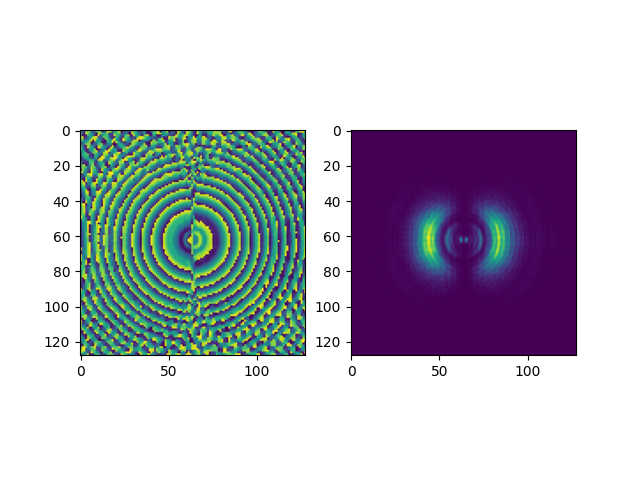

In [146]:
fig, (ax1, ax2) = pyplot.subplots(ncols=2)

ax1.imshow(to_numpy(xp.angle(delta_P_x[5, 0])))
ax2.imshow(to_numpy(abs2(delta_P_x[5, 0])))

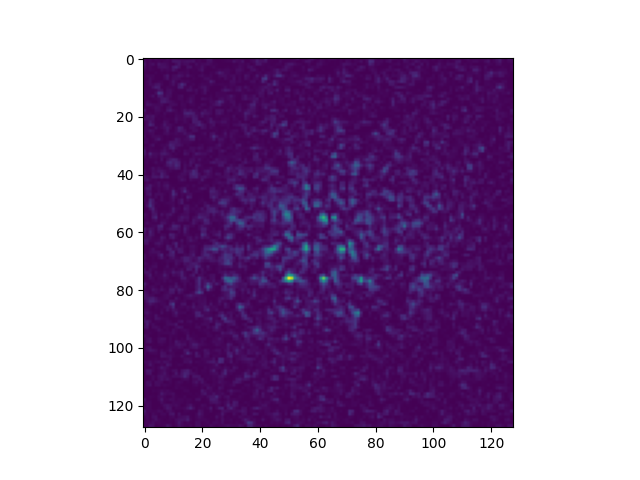

In [11]:
fig, ax = pyplot.subplots()

i = 15

ax.imshow(abs2(to_numpy(chi[i, 0])))